In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pickle
import time

In [ ]:
pwd

'/mnt/lustre/kucc233/captiongram'

### Flickr dataset is used for training. It had around 32K images, and each image have 5 captions describing it.
<br/>
Source for data: <a href="https://www.kaggle.com/hsankesara/flickr-image-dataset"> Kaggle</a> 

In [ ]:
image_folder_path="/mnt/lustre/kucc233/captiongram/dataset/flickr30k_images/"

In [ ]:
data=pd.read_csv("/mnt/lustre/kucc233/captiongram/dataset/results.csv")

In [ ]:
data.head(20)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,Two young <COMMA_TOKEN> White males are outsi...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


In [ ]:
data[' comment']=[str(x).replace("<COMMA_TOKEN>" , ",") for x in data[' comment']]

In [ ]:
data.head(20)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


In [ ]:
data[" comment"]=data[" comment"].apply(lambda x: "<start> "+x+ " <end>")

In [ ]:
img_name_vector=[]
for image_name in data['image_name']:
    img_name_vector.append(image_folder_path+image_name)

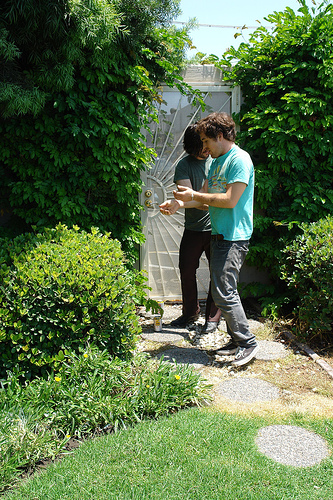

In [ ]:
#loading a random image 
tf.keras.preprocessing.image.load_img(img_name_vector[0])

In [ ]:
train_captions=data[' comment'].copy()

In [ ]:
len(img_name_vector),len(train_captions)

(158915, 158915)

In [ ]:
len(sorted(set(img_name_vector)))

31783

In [ ]:
def load_image(image_path):
    path="/mnt/lustre/kucc233/captiongram/dataset/flickr30k_images/"+image_path
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img,(299,299))
    img=preprocess_input(img)
    final_path="/mnt/lustre/kucc233/captiongram/feature_extracted/"+image_path
    return img,final_path

## Feature extracting model

Inception is used here. The input layer and the output of final layer of inception is used to make feature extractor model. This model extracts features from images which is later saved as .npy file for training.

In [ ]:
inception=InceptionV3(include_top=False,weights="imagenet")
for layer in inception.layers:
    layer.trainable=False
input_layer=inception.input
out_layer=inception.layers[-1].output
image_features_extract_model=Model(input_layer,out_layer)

87916544/87910968 [==============================] - 39s 0us/step


In [ ]:
img_vector=[]
for vector in img_name_vector:
    img_vector.append(vector.split("/")[-1])
image_train=sorted(set(img_vector))
image_dataset=tf.data.Dataset.from_tensor_slices(image_train)
image_dataset=image_dataset.map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

## saving extracted features in .npy file

In [ ]:
for img,path in tqdm(image_dataset):
    batch_features=image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    
    for feature,p in zip(batch_features,path):
        path_to_features=p.numpy().decode('utf-8')
        np.save(path_to_features,feature.numpy())

1987it [10:48,  3.06it/s]


In [ ]:
final_img_name_vector=[]
for vector in img_vector:
    final_img_name_vector.append("/mnt/lustre/kucc233/captiongram/feature_extracted/"+vector)
final_img_name_vector[0]

'/mnt/lustre/kucc233/captiongram/feature_extracted/1000092795.jpg'

In [ ]:
num_top=5000
tokenizer=Tokenizer(num_words=num_top,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_sequences = tokenizer.texts_to_sequences(train_captions)                                              

In [ ]:
tokenizer.word_index['<pad>']=0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(train_captions) #tokenizing with '<pad>' inclusive

In [ ]:
padded_vector=pad_sequences(train_seqs, padding='post')

In [ ]:
max_length=max(len(t) for t in train_seqs)

In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(final_img_name_vector,padded_vector,test_size=0.2,random_state=0)                                                                                                                                                                                                        

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(127132, 127132, 31783, 31783)

In [ ]:
#Hyperparameters
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = num_top + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

In [ ]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

## Creating training dataset

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):  
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "/mnt/lustre/kucc233/captiongram/checkpoints/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=6)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
loss=[]

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1) #teacher forcing

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 21

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()
        print("saved to checkpoints")

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.6116
Epoch 1 Batch 100 Loss 0.8025
Epoch 1 Batch 200 Loss 0.7454
Epoch 1 Batch 300 Loss 0.7214
Epoch 1 Batch 400 Loss 0.7096
Epoch 1 Batch 500 Loss 0.6759
Epoch 1 Batch 600 Loss 0.5916
Epoch 1 Batch 700 Loss 0.5868
Epoch 1 Batch 800 Loss 0.6145
Epoch 1 Batch 900 Loss 0.6332
Epoch 1 Batch 1000 Loss 0.5817
Epoch 1 Batch 1100 Loss 0.5581
Epoch 1 Batch 1200 Loss 0.6421
Epoch 1 Batch 1300 Loss 0.6188
Epoch 1 Batch 1400 Loss 0.5710
Epoch 1 Batch 1500 Loss 0.5647
Epoch 1 Batch 1600 Loss 0.5049
Epoch 1 Batch 1700 Loss 0.5777
Epoch 1 Batch 1800 Loss 0.5462
Epoch 1 Batch 1900 Loss 0.5274
saved to checkpoints
Epoch 1 Loss 0.632694
Time taken for 1 epoch 1757.0323705673218 sec

Epoch 2 Batch 0 Loss 0.5876
Epoch 2 Batch 100 Loss 0.5958
Epoch 2 Batch 200 Loss 0.5536
Epoch 2 Batch 300 Loss 0.5883
Epoch 2 Batch 400 Loss 0.6297
Epoch 2 Batch 500 Loss 0.5746
Epoch 2 Batch 600 Loss 0.5403
Epoch 2 Batch 700 Loss 0.6168
Epoch 2 Batch 800 Loss 0.5882
Epoch 2 Batch 900 Loss 0.5137
Epoc

Epoch 13 Batch 0 Loss 0.4205
Epoch 13 Batch 100 Loss 0.3799
Epoch 13 Batch 200 Loss 0.3796
Epoch 13 Batch 300 Loss 0.3715
Epoch 13 Batch 400 Loss 0.4316
Epoch 13 Batch 500 Loss 0.3090
Epoch 13 Batch 600 Loss 0.3263
Epoch 13 Batch 700 Loss 0.3826
Epoch 13 Batch 800 Loss 0.3384
Epoch 13 Batch 900 Loss 0.3686
Epoch 13 Batch 1000 Loss 0.3804
Epoch 13 Batch 1100 Loss 0.4014
Epoch 13 Batch 1200 Loss 0.3714
Epoch 13 Batch 1300 Loss 0.3658
Epoch 13 Batch 1400 Loss 0.3900
Epoch 13 Batch 1500 Loss 0.3750
Epoch 13 Batch 1600 Loss 0.4105
Epoch 13 Batch 1700 Loss 0.3701
Epoch 13 Batch 1800 Loss 0.3880
Epoch 13 Batch 1900 Loss 0.3415
Epoch 13 Loss 0.381582
Time taken for 1 epoch 1511.3624064922333 sec

Epoch 14 Batch 0 Loss 0.3544
Epoch 14 Batch 100 Loss 0.3740
Epoch 14 Batch 200 Loss 0.3936
Epoch 14 Batch 300 Loss 0.4302
Epoch 14 Batch 400 Loss 0.3782
Epoch 14 Batch 500 Loss 0.3675
Epoch 14 Batch 600 Loss 0.3170
Epoch 14 Batch 700 Loss 0.3899
Epoch 14 Batch 800 Loss 0.3844
Epoch 14 Batch 900 Loss 0

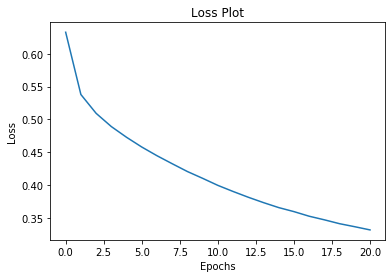

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def load_image2(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img,(299,299))
    img=preprocess_input(img)
    return img,image_path

## Inference

In [ ]:
def evaluate(image):

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image2(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)


        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [ ]:
def show_image(image_path):
    img=plt.imread(image_path)
    plt.imshow(img)
    result=evaluate(image_path)
    print(" ".join(result))

three soccer players in soccer uniforms run through a soccer field <end>


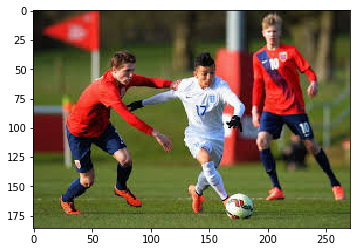

In [ ]:
show_image("football.jpeg")

two dogs in a red collar <end>


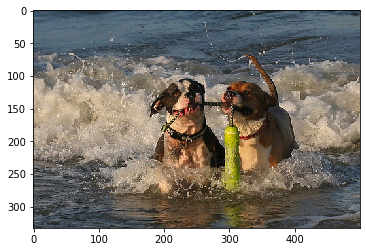

In [ ]:
show_image(img_name_vector[2000])

one person in red shirt is reading from two people and looking at a half pipe <end>


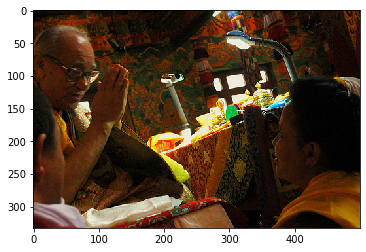

In [ ]:
show_image(img_name_vector[30000])

a man with his gloves is holding something under a garden <end>


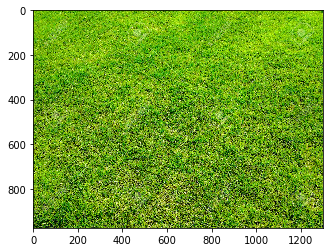

In [ ]:
show_image("green.jpg") 
#The model seems to be somewhat biased :P, pictures of ground usually had men in its training caption.

a young girl in swimsuits and a <unk> sitting in the ledge and one in the mud <end>


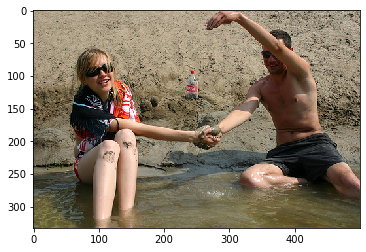

In [ ]:
show_image(img_name_vector[1570])

a brown dog is digging in the sand <end>


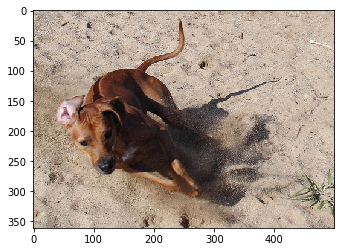

In [ ]:
show_image(img_name_vector[1800])